# Termos Clínicos e Mapeamento com UMLS


2. Geração de matrizes termo-documento e TF-IDF.
3. Extração dos termos mais importantes.
4. Consulta dos CUIs via API do UMLS.
5. Representação vetorial por CUI.
6. Visualização dos termos mais frequentes.

In [1]:
# Substitua pela sua chave da API do UMLS
api_key = '6849045a-3563-4d63-b939-fc053b058c09'

### 1. Recebe um termo clínico, acessa a API e retorna os termos mais próximos encontrados na UMLS.

In [2]:
import requests

def buscar_termos_umls(termo, api_key, max_resultados=5, search_type='words'):
    """
    - termo (str): O termo clínico a ser pesquisado.
    - api_key (str): Sua chave de API do UMLS.
    - max_resultados (int): Número máximo de resultados a retornar.
    - search_type (str): Tipo de busca ('words', 'exact', 'normalizedString', etc.).
    """
    url = "https://uts-ws.nlm.nih.gov/rest/search/current"
    params = {
        "string": termo,
        "apiKey": api_key,
        "pageSize": max_resultados,
        "searchType": search_type
    }

    try:
        resposta = requests.get(url, params=params)
        resposta.raise_for_status()
        dados = resposta.json()
        resultados = dados.get("result", {}).get("results", [])
        termos_encontrados = [(item.get("name"), item.get("ui")) for item in resultados]
        return termos_encontrados
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        return []

termo_clinico = 'bruxismo'

resultados = buscar_termos_umls(termo_clinico, api_key)

for nome, cui in resultados:
    print(f"Termo: {nome} | CUI: {cui}")


Termo: Bruxism | CUI: C0006325
Termo: Sleep Bruxism | CUI: C0751771
Termo: Bruxism aggravated | CUI: C0877360
Termo: Sleep-Related Bruxism | CUI: C0393774


### 2. Abre os textos clínicos dos diretórios que finalizam com “Raw” disponíveis no repositório (https://github.com/kunkaweb/PortugueseClinicalNER.git)

In [3]:
import os

def ler_textos_raw(caminho_repositorio):
    textos = []
    for raiz, dirs, arquivos in os.walk(caminho_repositorio):
        # Verifica se o diretório atual termina com 'Raw'
        if os.path.basename(raiz).endswith("Raw"):
            for nome_arquivo in arquivos:
                if nome_arquivo.endswith(".txt"):
                    caminho_arquivo = os.path.join(raiz, nome_arquivo)
                    try:
                        with open(caminho_arquivo, 'r', encoding='latin-1') as arquivo:
                            conteudo = arquivo.read()
                            textos.append(conteudo)
                    except Exception as e:
                        print(f"Erro ao ler {caminho_arquivo}: {e}")
    return textos

# Exemplo de uso
caminho_repositorio = "./PortugueseClinicalNER"  # Substitua pelo caminho correto
textos_clinicos = ler_textos_raw(caminho_repositorio)

# Exibe a quantidade de textos lidos
print(f"Total de textos clínicos lidos: {len(textos_clinicos)}")


Total de textos clínicos lidos: 281


### 3. Gera a matriz termo-documento da base de dados utilizando n-grams (bag of words)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def gerar_matriz_termo_documento(textos, ngram_range=(1, 2), max_features=None):
    """
    Gera a matriz termo-documento a partir de uma lista de textos clínicos.

    Parâmetros:
    - textos (list): Lista de strings, cada uma representando um documento.
    - ngram_range (tuple): Ex: (1, 2) inclui unigramas e bigramas.
    - max_features (int): Número máximo de termos a considerar (opcional).

    Retorna:
    - matriz (sparse matrix): Matriz termo-documento.
    - vetorizar (CountVectorizer): Vetorizador treinado (contém os termos).
    """
    vetorizar = CountVectorizer(ngram_range=ngram_range, 
                                 stop_words='english', 
                                 max_features=max_features)
    matriz = vetorizar.fit_transform(textos)
    return matriz, vetorizar

# Suponha que `textos_clinicos` já contenha os textos lidos
matriz_td, vetor_bow = gerar_matriz_termo_documento(textos_clinicos, ngram_range=(1, 2))

# Exibir tamanho da matriz: (n_docs, n_termos)
print("Formato da matriz termo-documento:", matriz_td.shape)

# Exibir os primeiros 20 termos do vocabulário
print("Exemplo de termos:", vetor_bow.get_feature_names_out()[:20])



Formato da matriz termo-documento: (281, 33653)
Exemplo de termos: ['000' '000 mm3' '03mm' '03mm 15mm' '04' '04 06' '06' '06 10' '06 mg'
 '07mg' '07mg dl' '10' '10 12mm' '10 24' '10 30' '10 anos' '10 bandas'
 '10 boc' '10 dias' '10 exão']


### 4. Gerar a matriz termo-documento da base de dados utilizando n-grams (bag of words)

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

def gerar_matriz_tfidf(matriz_termo_documento):
    """
    Converte uma matriz termo-documento (Bag of Words) em matriz TF-IDF.

    Parâmetros:
    - matriz_termo_documento (sparse matrix): Saída do CountVectorizer.

    Retorna:
    - matriz_tfidf (sparse matrix): Matriz com os pesos TF-IDF.
    - tfidf_transformer (TfidfTransformer): Transformador treinado.
    """
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(matriz_termo_documento)
    return matriz_tfidf, tfidf_transformer

# matriz_td vem do CountVectorizer
matriz_tfidf, tfidf = gerar_matriz_tfidf(matriz_td)

# Verificar o formato da matriz TF-IDF
print("Formato da matriz TF-IDF:", matriz_tfidf.shape)



Formato da matriz TF-IDF: (281, 33653)


### 5. Gere a matriz de pesos TF-IDF da base

In [7]:
import numpy as np

def extrair_top_termos_por_documento(matriz_tfidf, vetorizar, top_n=10):
    """
    Retorna os top N termos com maior peso TF-IDF por documento.

    Parâmetros:
    - matriz_tfidf: Matriz gerada pelo TfidfTransformer.
    - vetorizar: Instância do CountVectorizer treinada.
    - top_n: Número de termos relevantes a retornar por documento.

    Retorna:
    - Lista de listas com os termos mais importantes por documento.
    """
    termos = vetorizar.get_feature_names_out()
    top_termos_por_doc = []

    for i in range(matriz_tfidf.shape[0]):
        vetor = matriz_tfidf[i].toarray()[0]
        indices_top = vetor.argsort()[-top_n:][::-1]
        termos_top = [termos[idx] for idx in indices_top]
        top_termos_por_doc.append(termos_top)

    return top_termos_por_doc

top_termos = extrair_top_termos_por_documento(matriz_tfidf, vetor_bow)

# Exemplo: mostrar os termos mais relevantes do primeiro documento
print("Top termos do primeiro documento:")
print(top_termos[0])


Top termos do primeiro documento:
['estenose da', 'acp direita', 'hemiparesia', 'oclusão', 'esquerda grau', 'da acp', 'pulsos', 'acp', 'esquerda', 'oclusão da']


### 6. Enviar os top 10 termos mais importantes de cada nota clínica para a API e obter seus CUIs

In [21]:
import requests
import time

def obter_cuis_para_termos(top_termos_por_doc, api_key, delay=0.5, limite_docs=2):
    """
    Consulta a API UMLS para obter os CUIs dos termos clínicos mais relevantes.

    Parâmetros:
    - top_termos_por_doc: Lista de listas com os top N termos por documento.
    - api_key: Chave de acesso à API do UMLS.
    - delay: Tempo de espera entre requisições para evitar bloqueio.

    Retorna:
    - Lista de listas com os CUIs correspondentes por documento.
    """
    base_url = "https://uts-ws.nlm.nih.gov/rest/search/current"
    resultados_cuis = []

    for termos_doc in top_termos_por_doc[:limite_docs]: 
        cuis = []
        for termo in termos_doc:
            try:
                params = {
                    "string": termo,
                    "apiKey": api_key,
                    "pageSize": 1,
                    "searchType": "words"
                }
                resposta = requests.get(base_url, params=params)
                resposta.raise_for_status()
                dados = resposta.json()
                resultado = dados.get("result", {}).get("results", [])
                if resultado:
                    cui = resultado[0].get("ui")
                    cuis.append(cui)
                else:
                    cuis.append(None)
            except Exception as e:
                print(f"Erro ao buscar '{termo}': {e}")
                cuis.append(None)
            time.sleep(delay)  # evita excesso de chamadas em sequência
        resultados_cuis.append(cuis)
    
    return resultados_cuis


# top_termos foi gerado na etapa anterior com TF-IDF
cuis_por_documento = obter_cuis_para_termos(top_termos, api_key, 0.5, 20)

# Visualizar os CUIs obtidos para o primeiro documento
print("CUIs do primeiro documento:")
print(cuis_por_documento[0])


CUIs do primeiro documento:
['C0003507', None, 'C0018989', 'C0024636', 'C1525777', None, 'C0241760', 'C0394005', 'C0023212', 'C0265101']


### 7. Criar vetores de CUIs representando cada nota clínica e imprimir

In [22]:
def representar_notas_por_cuis(cuis_por_documento):
    """
    Constrói um vetor de CUIs para cada nota clínica.

    Parâmetro:
    - cuis_por_documento: Lista de listas com CUIs dos termos de cada documento.

    Retorna:
    - Lista de vetores de CUIs (um por documento).
    """
    vetores = []
    for cuis in cuis_por_documento:
        vetor = [cui if cui else "N/A" for cui in cuis]  # "N/A" para CUIs não encontrados
        vetores.append(vetor)
    return vetores

vetores_cuis = representar_notas_por_cuis(cuis_por_documento)

# Imprimir os vetores de CUIs dos primeiros 5 documentos
for i, vetor in enumerate(vetores_cuis[:5]):
    print(f"Documento {i+1} → CUIs: {vetor}")


Documento 1 → CUIs: ['C0003507', 'N/A', 'C0018989', 'C0024636', 'C1525777', 'N/A', 'C0241760', 'C0394005', 'C0023212', 'C0265101']
Documento 2 → CUIs: ['C0405580', 'C0019004', 'C0023467', 'C0412585', 'C0751495', 'C0719635', 'C4538276', 'C0040405', 'C0012222', 'C0228174']
Documento 3 → CUIs: ['C1961011', 'C0231170', 'N/A', 'N/A', 'N/A', 'C1550151', 'C0231666', 'C0392485', 'C0006382', 'C0033204']
Documento 4 → CUIs: ['C1095546', 'C0750197', 'C5779771', 'C4087267', 'C0034933', 'C0026896', 'C0453996', 'N/A', 'C0404391', 'N/A']
Documento 5 → CUIs: ['C0043387', 'N/A', 'N/A', 'C5234771', 'C0031315', 'C1999039', 'N/A', 'N/A', 'N/A', 'C0040446']


### 8. Plotar os termos (nome do termo + CUI) mais importantes do dataset

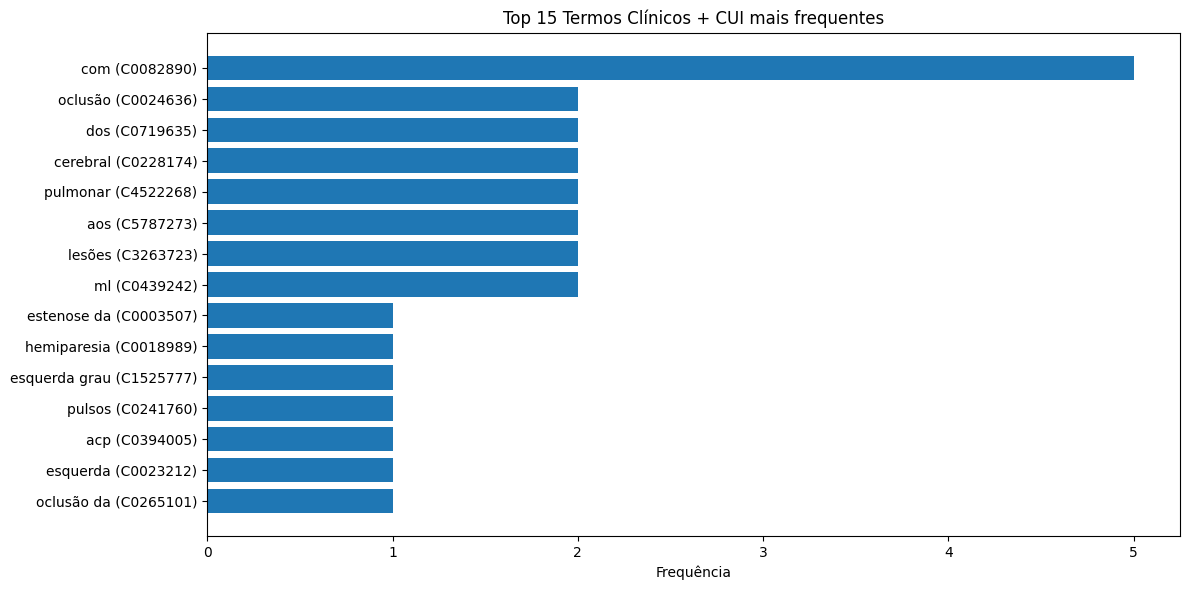

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

def plotar_termos_cuis_mais_frequentes(top_termos, cuis_por_documento, top_n=10):
    """
    Plota os termos + CUI mais frequentes em todo o dataset.

    Parâmetros:
    - top_termos: Lista de listas com os top termos por documento.
    - cuis_por_documento: Lista de listas com os CUIs correspondentes.
    - top_n: Número de pares a exibir no gráfico.
    """
    pares_termo_cui = []

    for termos, cuis in zip(top_termos, cuis_por_documento):
        for termo, cui in zip(termos, cuis):
            if cui:  # ignora None
                pares_termo_cui.append(f"{termo} ({cui})")

    contagem = Counter(pares_termo_cui)
    mais_frequentes = contagem.most_common(top_n)
    
    labels, valores = zip(*mais_frequentes)

    plt.figure(figsize=(12, 6))
    plt.barh(labels, valores)
    plt.xlabel("Frequência")
    plt.title(f"Top {top_n} Termos Clínicos + CUI mais frequentes")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plotar_termos_cuis_mais_frequentes(top_termos, cuis_por_documento, top_n=15)
